# 1. Introduction
### Overview
This week's project requires us to implement a K-nearest neighbor (KNN) classifier on the Titanic dataset. Once we conduct the experiments, we will calculate the resulting metrics.

### 1.1 Research Question
We are expected to use KNN to predict whether a passenger aboard the Titanic survived or not.

### 1.2 Metric for Success
Our model would be considered a success if it is able to compute an accuracy score of at least 80%. 

### 1.3 Context
The RMS Titanic was a British ship that crashed into an iceberg and led to the untimely demise of hundreds of passengers on its maiden voyage in April 1912.

### 1.4 Experimental Design
1. Prepare dataset(s) and clean them
2. Carry out exhaustive EDA
3. Carry out modelling using KNN
4. Optimize the KNN model
5. Challenge the Solution
6. Document everything.

### 1.5 Appropriateness of Data
I found the data to be very appropriate for the task. However, in some cases, it would have been better if the variables were a bit more clear. For example, on the 'Parch' variable, I did not understand whether it meant that the passenger had a parent or a child with them or both. The same can be said for the 'SibSp' variable. 

# 2. Data Preparation & Cleaning

In [1]:
# importing basic Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# loading & previewing train dataset
train = pd.read_csv('train.csv', index_col = 'PassengerId')
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# loading & previewing test dataset
test = pd.read_csv('test.csv', index_col = 'PassengerId')
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# dropping Name, Ticket, and Cabin since I consider them useless when it comes
# to determining whether or not someone will survive
train.drop(columns = ['Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)
test.drop(columns = ['Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)

In [5]:
print("The 'train' dataset has", train.shape[0], 
      "rows and", train.shape[1], "columns.")
print("The 'test' dataset has", test.shape[0],
      "rows and", test.shape[1], "columns.")

The 'train' dataset has 891 rows and 8 columns.
The 'test' dataset has 418 rows and 7 columns.


In [6]:
# dropping duplicates, if any
train = train.drop_duplicates()
test = test.drop_duplicates()
print("New 'train' dataset shape:", train.shape)
print("New 'test' dataset shape:", test.shape)

New 'train' dataset shape: (780, 8)
New 'test' dataset shape: (380, 7)


In [7]:
# checking basic info
train.info()
print("\n")
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 1 to 891
Data columns (total 8 columns):
Survived    780 non-null int64
Pclass      780 non-null int64
Sex         780 non-null object
Age         676 non-null float64
SibSp       780 non-null int64
Parch       780 non-null int64
Fare        780 non-null float64
Embarked    778 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 54.8+ KB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 892 to 1309
Data columns (total 7 columns):
Pclass      380 non-null int64
Sex         380 non-null object
Age         322 non-null float64
SibSp       380 non-null int64
Parch       380 non-null int64
Fare        379 non-null float64
Embarked    380 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 23.8+ KB


In [8]:
# checking for null values
print(train.isna().sum())
print("\n")
print(test.isna().sum())

Survived      0
Pclass        0
Sex           0
Age         104
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


Pclass       0
Sex          0
Age         58
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64


The 'train' dataset is missing 2 values in its Embarked column while the 'test' dataset is missing one value in its Fare column. Both of these can be fixed by dropping their respecive records.

In [9]:
train = train.dropna(subset = ['Embarked'])
test = test.dropna(subset = ['Fare'])
print("Missing values in train's Embarked column:", train.Embarked.isna().any())
print("Missing values in test's Fare column:", test.Fare.isna().any())

Missing values in train's Embarked column: False
Missing values in test's Fare column: False


As for the missing values in the Age column (104 for 'train' and 58 for 'test). We will look at their box plots to see how many outliers they each have. If there are many outliers, we will impute with the mean, otherwise we will replace the missing values with the column's median.

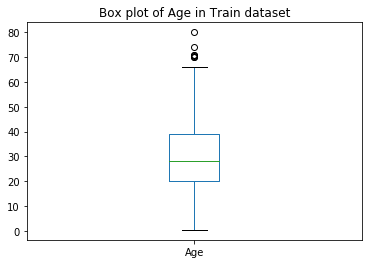

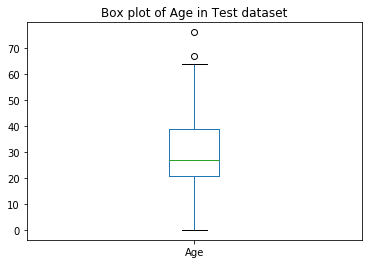

In [10]:
ds = [train, test]
train.name = 'Train'
test.name = 'Test'

for data in ds:
    data.Age.plot(kind = "box")
    plt.title("Box plot of Age in {} dataset".format(data.name))
    plt.show()

Both data sets do not have many outliers so we will replace the missing values with the mean.

In [11]:
train = train.fillna(train.Age.mean())
test = test.fillna(test.Age.mean())
print("Missing values in Train dataset:")
print(train.isna().any())
print("\nMissing values in Test dataset:")
print(test.isna().any())

Missing values in Train dataset:
Survived    False
Pclass      False
Sex         False
Age         False
SibSp       False
Parch       False
Fare        False
Embarked    False
dtype: bool

Missing values in Test dataset:
Pclass      False
Sex         False
Age         False
SibSp       False
Parch       False
Fare        False
Embarked    False
dtype: bool


Our datasets now have been cleaned of all missing values.

I have noticed something odd about the Age columns in both datasets. They are of data type float which does not make sense and also have values such as 0.42. We will convert these columns to int so that the datasets will make logical sense and provide realistic predictions.

In [12]:
train = train.astype({'Age' : 'int'})
test = test.astype({'Age' : 'int'})

# confirming that the data types have been changed
print("Train Age data type:", train.Age.dtype)
print("Test Age data type:", test.Age.dtype)

Train Age data type: int64
Test Age data type: int64


In [13]:
# dropping extra duplicates, if any were created
train = train.drop_duplicates()
test = test.drop_duplicates()
print("New 'train' dataset shape:", train.shape)
print("New 'test' dataset shape:", test.shape)

New 'train' dataset shape: (772, 8)
New 'test' dataset shape: (377, 7)


We now need to encode our categorical variables before we save our datasets so that it will be easy carrying out modeling in case some functions such as regression require non-categorical data.

In [14]:
from sklearn.preprocessing import LabelEncoder 
encoder = LabelEncoder()

# columns to encode
to_encode = ['Sex', 'Embarked']

# dictionary to store each unique variable class
class_dict = {}

for item in to_encode:
    encoder = LabelEncoder().fit(train[item].unique())
    classed = encoder.classes_
    class_dict[item] = classed
    # encoding in 'train' dataset
    train[item] = encoder.transform(train[item].values)
    # encoding in 'test' dataset since it has the same unique values as the 'train' dataset
    test[item] = encoder.transform(test[item].values)

# to decode, use the following structure
class_dict['Sex'][0]

'female'

In [15]:
# saving our cleaned datasets
train.to_csv('train_cleaned.csv', index = False)
test.to_csv('test_cleaned.csv', index = False)

# train = pd.read_csv('train_cleaned.csv')
# test = pd.read_csv('test_cleaned.csv')

In [16]:
# combining both train and test datasets
dataset = pd.concat([train, test], sort = False)
dataset.shape

(1149, 8)

In [17]:
# previewing basic info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149 entries, 1 to 1309
Data columns (total 8 columns):
Survived    772 non-null float64
Pclass      1149 non-null int64
Sex         1149 non-null int64
Age         1149 non-null int64
SibSp       1149 non-null int64
Parch       1149 non-null int64
Fare        1149 non-null float64
Embarked    1149 non-null int64
dtypes: float64(2), int64(6)
memory usage: 80.8 KB


In [18]:
# change Survived from float to category
dataset = dataset.astype({'Survived' : 'category'})
dataset.Survived.dtypes

CategoricalDtype(categories=[0.0, 1.0], ordered=False)

In [19]:
# dropping duplicates, if any are present
dataset = dataset.drop_duplicates()
print("New dataset shape:", dataset.shape)

New dataset shape: (1149, 8)


No new duplicates were created so none were dropped.

In [20]:
# saving new dataset
dataset.to_csv('new_dataset.csv', index = False)
# dataset = pd.read_csv('new_dataset.csv')

# 3. Exploratory Data Analysis

### 3.1. Univariate Analysis

In [21]:
dataset.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,1149.000000,1149.000000,1149.000000,1149.000000,1149.000000,1149.000000,1149.000000
mean,2.235857,0.623151,29.821584,0.516971,0.426458,36.014596,1.484769
std,0.852892,0.484808,13.560113,0.971241,0.905383,54.372283,0.829016
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,22.000000,0.000000,0.000000,8.050000,1.000000
50%,3.000000,1.000000,29.000000,0.000000,0.000000,15.850000,2.000000
75%,3.000000,1.000000,36.000000,1.000000,1.000000,34.375000,2.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,2.000000


In [22]:
# Fare has a minimum value of 0 which is odd. Let's look at it
dataset.loc[dataset.Fare == 0.000]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
180,0.0,3,1,36,0,0,0.0,2
264,0.0,1,1,40,0,0,0.0,2
272,1.0,3,1,25,0,0,0.0,2
278,0.0,2,1,29,0,0,0.0,2
303,0.0,3,1,19,0,0,0.0,2
598,0.0,3,1,49,0,0,0.0,2
634,0.0,1,1,29,0,0,0.0,2
807,0.0,1,1,39,0,0,0.0,2
823,0.0,1,1,38,0,0,0.0,2


In [23]:
# decoding the encoded values
print("Sex:", class_dict['Sex'][1])
print("Embarked:", class_dict['Embarked'][2])

Sex: male
Embarked: S


We can see that the ones with a Fare of 0 are all males ranging from age 19 to 49, and they all embarked at location S. They all don't have parents, children, or siblings with them. Of these 11 from both the train and the test datasets combined, only 1 survived in the train dataset while the survival status of two of them is unknown. We can confidently say that the chances of survival are extremely low for those passengers in the test dataset who paid 0 and embarked at S.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6568148828>,
      dtype=object)

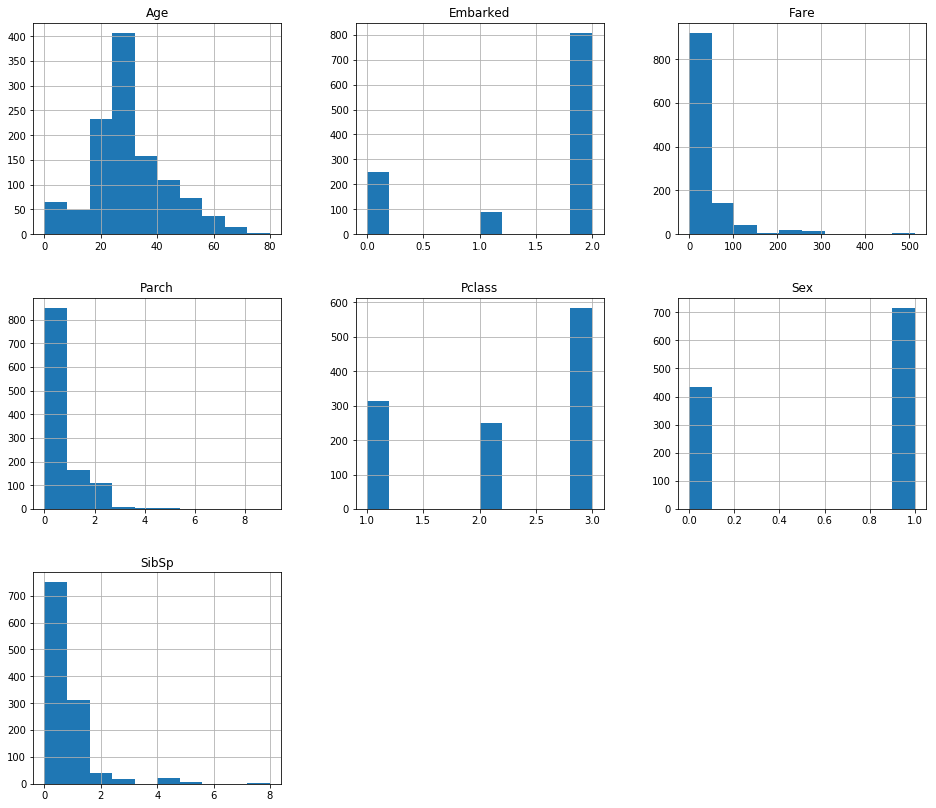

In [24]:
dataset.hist(figsize = [16, 14])

There is a lot of information to be gleaned from these diagrams.
- there is an age range from 0 to 80 with most of the passengers being between 22-32 years of age 
- most of them embarked at location S (code 2)
- most of them paid fare of between 0 to around 50
- the most common value for the Parch variable is 0 followed by 1
- most of the passengers were in 3rd class, and those in 1st class only slightly outnumber those in 2nd
- there were more men than women
- the most common value for the SibSp variable is 0 followed by 1

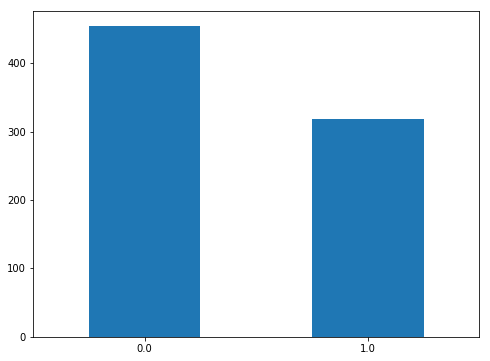

In [25]:
# viewing the countplot of those who survived vs those who didn't
dataset.Survived.value_counts().plot(kind = 'bar', rot = 0, figsize = [8, 6])

We see that majority of the passengers did not survive. However, those who survived are more than half of those who didn't.

In [26]:
# gender distribution
dataset.Sex.value_counts()

1    716
0    433
Name: Sex, dtype: int64

716 of the passengers were males while 433 were females.

In [27]:
# distribution of passengers across classes
dataset.Pclass.value_counts()

3    585
1    314
2    250
Name: Pclass, dtype: int64

Majority of the passengers were in 3rd class (585) followed by those in 1st class (314) followed by 2nd class (250).

In [28]:
# distribution across point of embarkment
dataset.Embarked.value_counts()

2    808
0    251
1     90
Name: Embarked, dtype: int64

In [29]:
print("2:", class_dict['Embarked'][2])
print("0:", class_dict['Embarked'][0])
print("1:", class_dict['Embarked'][1])

2: S
0: C
1: Q


808 embarked at point S, 251 embarked at point C and 90 embarked at point Q.

In [30]:
# parent-child distribution
dataset.Parch.value_counts()

0    851
1    166
2    108
3      8
5      6
4      6
9      2
6      2
Name: Parch, dtype: int64

- 851 didn't have any parent or child with them
- 166 had 1 parent or child with them
- 108 had 2 parents or children with them
- 8 had 3 parents or children with them
- 6 had 4 parents or children with them
- 6 had 5 parents or children with them
- 2 had 9 parents or children with them

In [31]:
# siblings/spouses distribution
dataset.SibSp.value_counts()

0    749
1    310
2     40
4     22
3     18
5      6
8      4
Name: SibSp, dtype: int64

- 749 didn't have any siblings or spouses with them
- 310 had 1 sibling or spouse with them
- 40 had 2 siblings or spouses with them
- 18 had 3 siblings or spouses with them
- 22 had 4 siblings or spouses with them
- 6 had 5 siblings or spouses with them
- 4 had 8 siblings or spouses with them

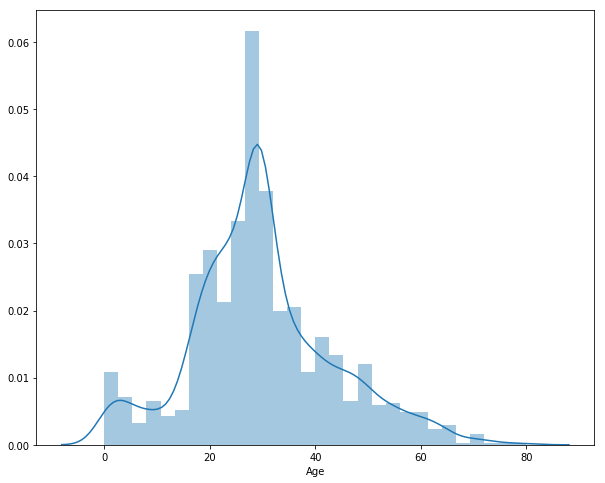

In [32]:
# distribution of age
fig, ax = plt.subplots(figsize = (10, 8))
sns.distplot(dataset.Age, ax = ax)

The distribution appears to be normal and leptokurtic.

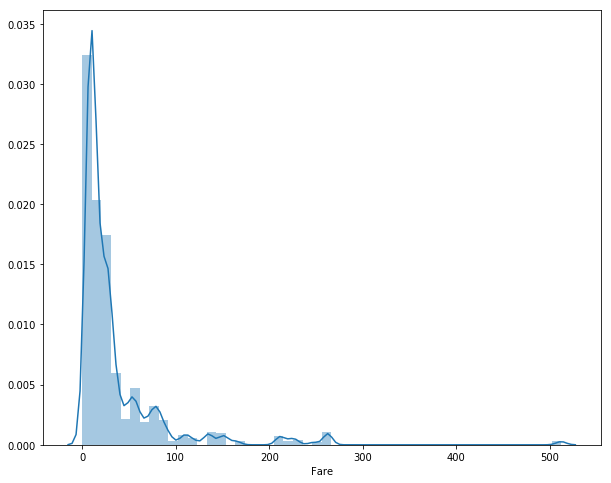

In [33]:
# fare distribution
fig, ax = plt.subplots(figsize = (10, 8))
sns.distplot(dataset.Fare, ax = ax)

The distribution for the Fares is positively skewed with majority of the values occuring between 0 and 280 while peaking at between 0 to 50. This shows that there are a lot of outliers in this column. We will not remove them because they could prove to be insightful.

### 3.2. Bivariate Analysis

Survived  Sex
0.0       1      378
          0       76
1.0       0      213
          1      105
Name: Sex, dtype: int64


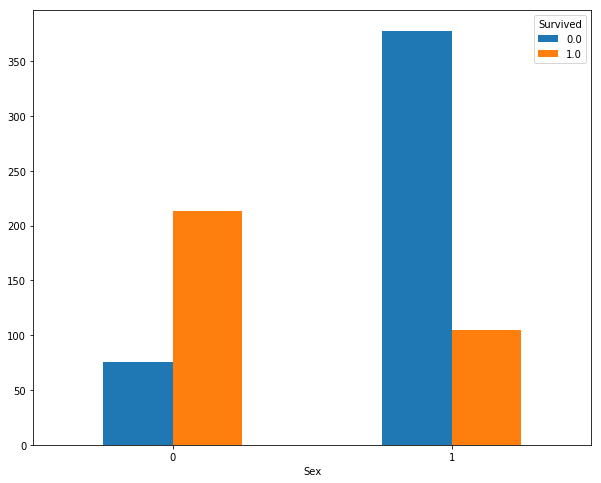

In [34]:
# survival status by gender
print(dataset.groupby('Survived').Sex.value_counts())
pd.crosstab(dataset.Sex, dataset.Survived).plot(kind = 'bar', rot = 0, figsize = [10, 8])

Of those who survived, majority are females (213) compared to males (105). Of those who didn't survive, males outnumber females 378 to 76.

Survived  Pclass
0.0       3         296
          2          81
          1          77
1.0       1         133
          3         103
          2          82
Name: Pclass, dtype: int64


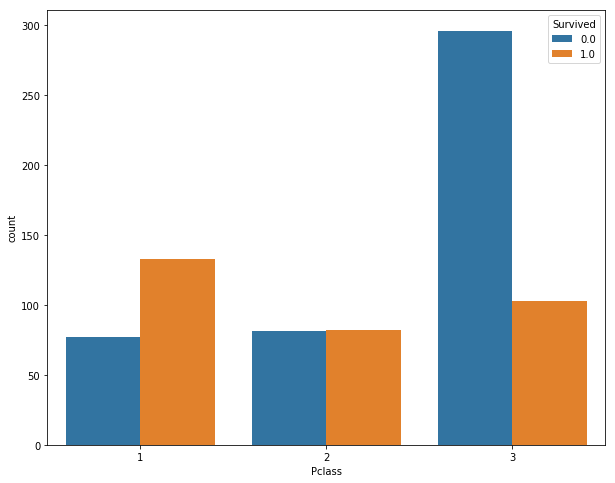

In [35]:
# survival status by class
print(dataset.groupby('Survived').Pclass.value_counts())

fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot('Pclass', hue = 'Survived', data = dataset, ax = ax)

Of those who didn't surive, 296 were in 3rd class, 81 were in 2nd class and 77 were in 1st class. Of those who did survive, 133 were in 1st class, 103 were in 3rd class and 82 were in 2nd class. It's clear that being in 1st class increased your chances of survival while it was a somewhat unpredictable gamble whether you survived or not if you were in 3rd class.

Survived  Parch
0.0       0        357
          1         51
          2         35
          4          4
          5          4
          3          2
          6          1
1.0       0        211
          1         63
          2         40
          3          3
          5          1
Name: Parch, dtype: int64


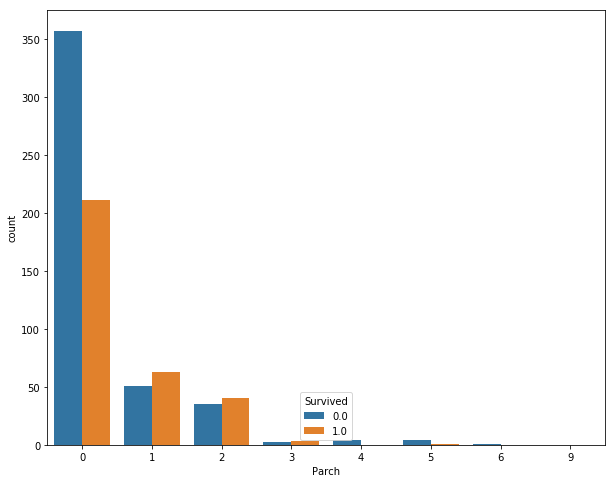

In [36]:
# survival status by parent-child
print(dataset.groupby('Survived').Parch.value_counts())

fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot('Parch', hue = 'Survived', data = dataset, ax = ax)

Of those who did not survive:
- 357 didn't have any parent or child with them
- 51 had 1 parent or child with them
- 35 had 2 parents or children with them
- 2 had 3 parents or children with them
- 4 had 4 parents or children with them
- 4 had 5 parents or children with them
- 1 had 6 parents or children with them

Of those who did survive:
- 211 didn't have any parent or child with them
- 63 had 1 parent or child with them
- 40 had 2 parents or children with them
- 3 had 3 parents or children with them
- 1 had 5 parents or children with them

An interesting thing to note here is that those who had 1, 2, or 3 parents or children with them outlasted those who didn't. For the rest, it did not seem to impact them greatly.

Survived  SibSp
0.0       0        313
          1         94
          2         15
          4         15
          3         10
          5          5
          8          2
1.0       0        192
          1        107
          2         12
          3          4
          4          3
Name: SibSp, dtype: int64


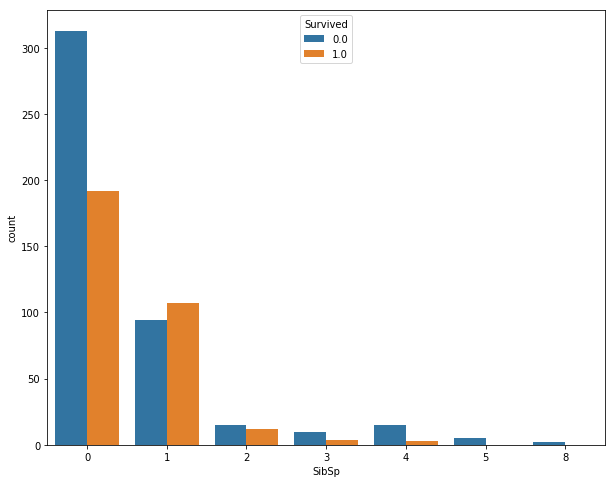

In [37]:
# survival status by siblings/spouses
print(dataset.groupby('Survived').SibSp.value_counts())

fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot('SibSp', hue = 'Survived', data = dataset, ax = ax)

Of those who did not survive:
- 313 didn't have any siblings or spouses with them
- 94 had 1 sibling or spouse with them
- 15 had 2 siblings or spouses with them
- 10 had 3 siblings or spouses with them
- 15 had 4 siblings or spouses with them
- 5 had 5 siblings or spouses with them
- 2 had 8 siblings or spouses with them

Of those who did survive:
- 192 didn't have any siblings or spouses with them
- 107 had 1 sibling or spouse with them
- 12 had 2 siblings or spouses with them
- 4 had 3 siblings or spouses with them
- 3 had 4 siblings or spouses with them

An interesting thing to note here is that those who survived and had 1 sibling or spouse with them outnumberes those who had the same number of siblings or spouses but did not survive. We could assume it is because they looked out for each other and it was easier to do so compared to when they had more than 1 sibling or spouse. 

Survived  Embarked
0.0       2           351
          0            65
          1            38
1.0       2           209
          0            90
          1            19
Name: Embarked, dtype: int64


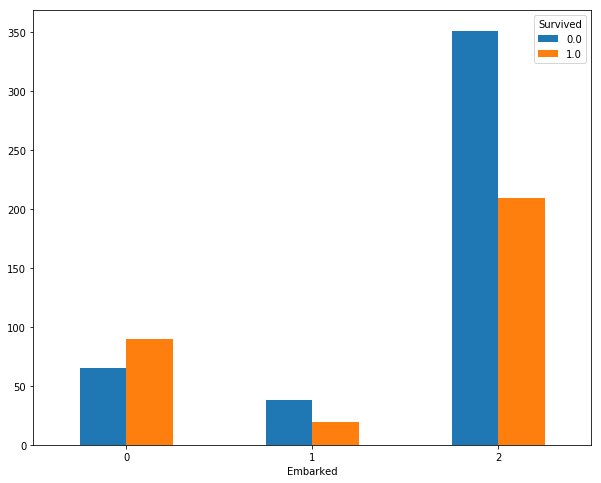

In [38]:
# survival by point of embarkment
print(dataset.groupby('Survived').Embarked.value_counts())
pd.crosstab(dataset.Embarked, dataset.Survived).plot(kind = 'bar', rot = 0, figsize = [10, 8])

Of those who didn't survive, 351 embarked at point S, 65 embarked at point C, and 38 embarked at point Q. 
Of those who survived, 209 embarked at point S, 90 embarked at point C, and 19 embarked at point Q.

It looks as if embarking at point C increases your chance of survival.

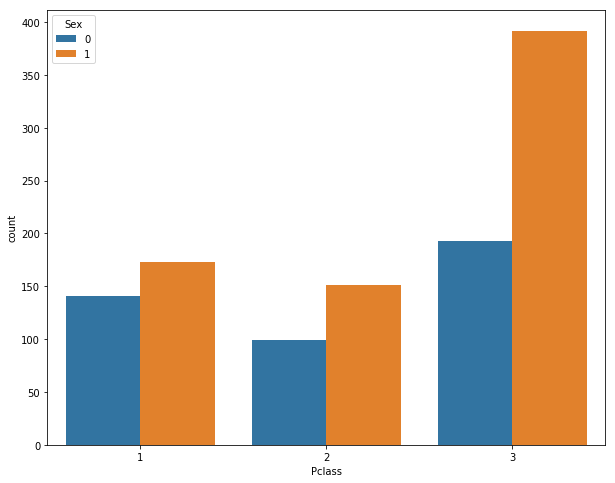

In [39]:
# class per gender
fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot('Pclass', hue = 'Sex', data = dataset, ax = ax)

In all classes, there were more males than females.

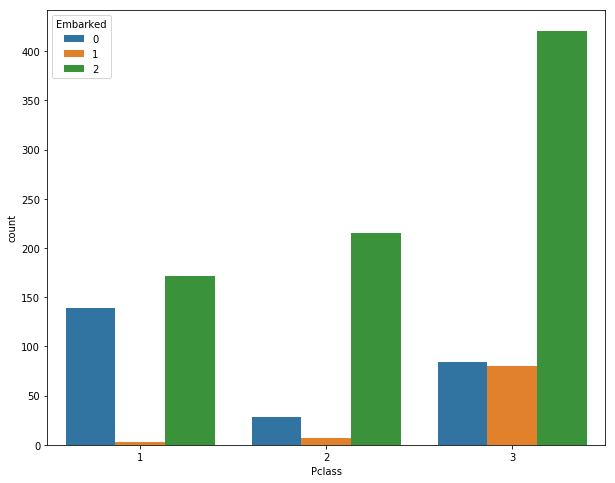

In [40]:
# class per point of embarkment
fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot('Pclass', hue = 'Embarked', data = dataset, ax = ax)

In all classes, those who embarked at point S make up the majority, followed by those who embarked at C then finally by those who embarked at Q. What's interesting is that in 3rd class, the number of those who embarked at C and those who embarked at Q are almost the same. Indeed, majority of those who embarked at Q are in 3rd class.

In [41]:
# splitting age into categories to make it easier to analyze
conditions = [
    ((dataset.Age >= 0) & (dataset.Age <= 10)),
    ((dataset.Age >= 11) & (dataset.Age <= 20)),
    ((dataset.Age >= 21) & (dataset.Age <= 30)),
    ((dataset.Age >= 31) & (dataset.Age <= 40)),
    ((dataset.Age >= 41) & (dataset.Age <= 50)),
    ((dataset.Age >= 51) & (dataset.Age <= 60)),
    ((dataset.Age >= 61) & (dataset.Age <= 70)),
    ((dataset.Age >= 71) & (dataset.Age <= 80))
]
choices = ['1', '2', '3', '4', '5', '6', '7', '8']

dataset['Age_range'] = np.select(conditions, choices)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f65665e9198>],
      dtype=object)

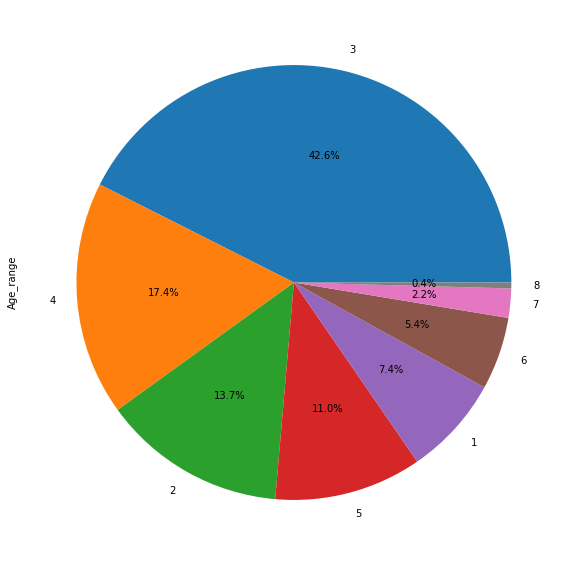

In [42]:
# plotting the age ranges in a pie chart
dataset.Age_range.value_counts().plot(kind = 'pie', autopct = '%0.1f%%', figsize = [12, 10], 
                                      subplots = True)

We see that age range 3 (20-30 year olds) make up the majority of the passengers while 70-80 year olds are the minority.

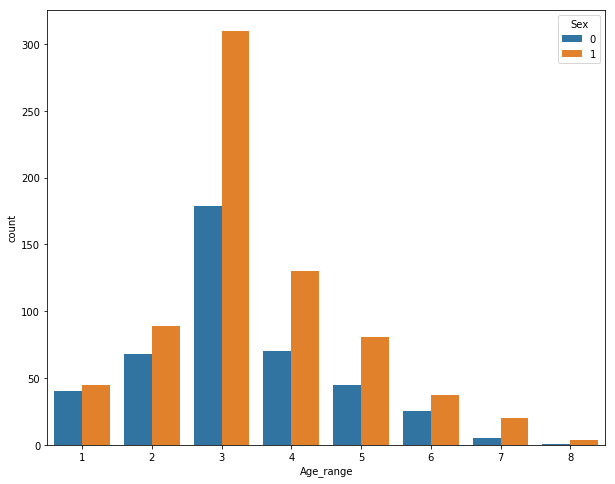

In [43]:
# age distribution per gender
fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot('Age_range', hue = 'Sex', data = dataset, ax = ax)

From this diagram, we can see that males outnumber females in all age ranges. This makes sense since this dataset has more males than females. As expected, age range 20-30 outnumber the other age ranges.

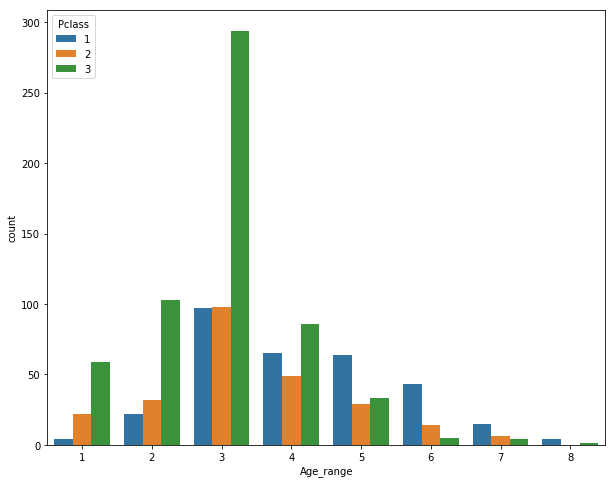

In [44]:
# age distribution per class
fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot('Age_range', hue = 'Pclass', data = dataset, ax = ax)

As expected, majority are in 3rd class. However, from 40 to 80 years of age, we see that the passengers in 1st class outnumber those in 3rd class. This could be due to the assumption that older people tend to have more money than younger people which makes sense considering they have had a much longer time to save up for the cruise.

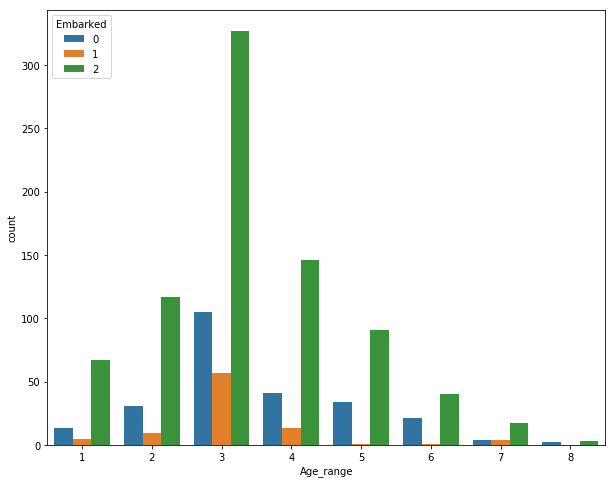

In [45]:
# age distribution per point of embarkment
fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot('Age_range', hue = 'Embarked', data = dataset, ax = ax)

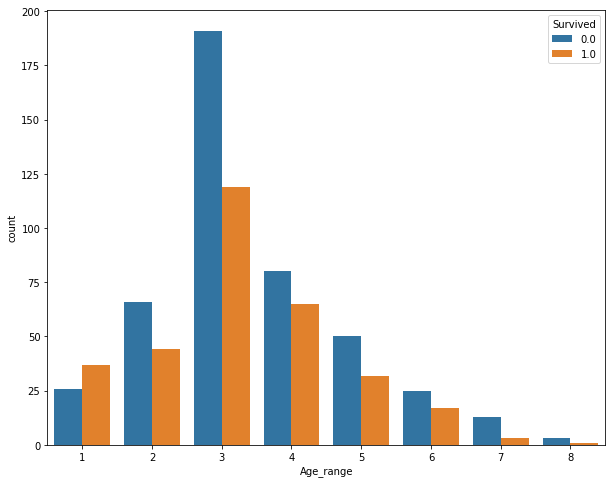

In [46]:
# survival status per age
fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot('Age_range', hue = 'Survived', data = dataset, ax = ax)

One thing that stands out about this diagram is that, of all the age ranges, age range 0 to 10 is the only one where the number of passengers who survived exceeds the number of those who did not. This is reasonable as children were prioritized over adults during the evacuation. However, I'm surprised that the same did not hold true for the elderly.

Max fare: 512.33


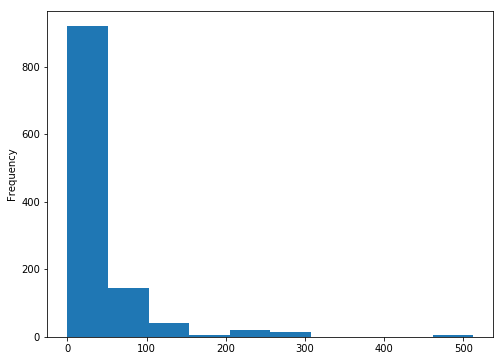

In [47]:
# to create categories for our Fare column, let's look at its distribution again
print("Max fare:", round(dataset.Fare.max(), 2))
dataset.Fare.plot(kind = 'hist', figsize = [8, 6])

In [48]:
conditions = [
    ((dataset.Fare >= 0) & (dataset.Fare <= 50)),
    ((dataset.Fare >= 51) & (dataset.Fare <= 100)),
    ((dataset.Fare >= 101) & (dataset.Fare <= 200)),
    ((dataset.Fare >= 201) & (dataset.Fare <= 300)),
    ((dataset.Fare >= 301) & (dataset.Fare <= 515))
]
choices = ['1', '2', '3', '4', '5']

dataset['Fare_range'] = np.select(conditions, choices)

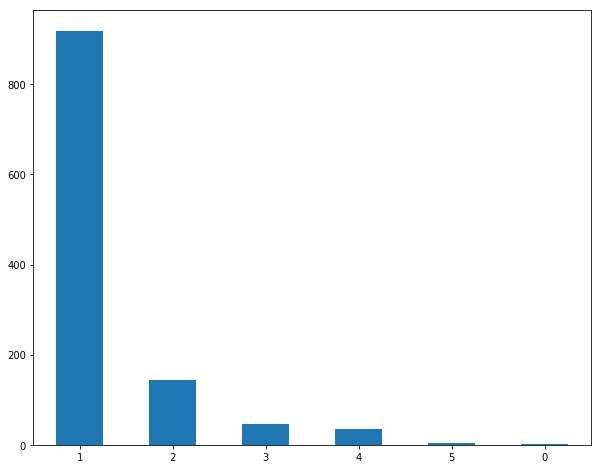

In [49]:
# plotting the fare ranges in a bar chart
dataset.Fare_range.value_counts().plot(kind = 'bar', figsize = [10, 8], rot = 0)

As expected, the most occuring fare is between 0 to 50.

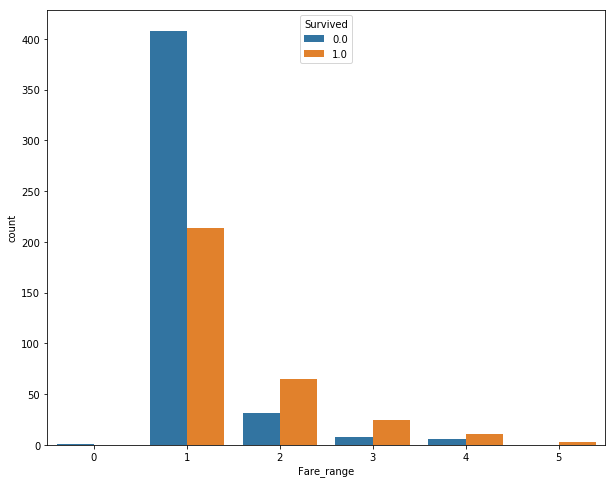

In [50]:
# survival status per fare
fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot('Fare_range', hue = 'Survived', data = dataset, ax = ax)

Those who paid 0-50 made up the majority of those who did not survive. In contrast, the rest had better chances of survival compared to these ones.

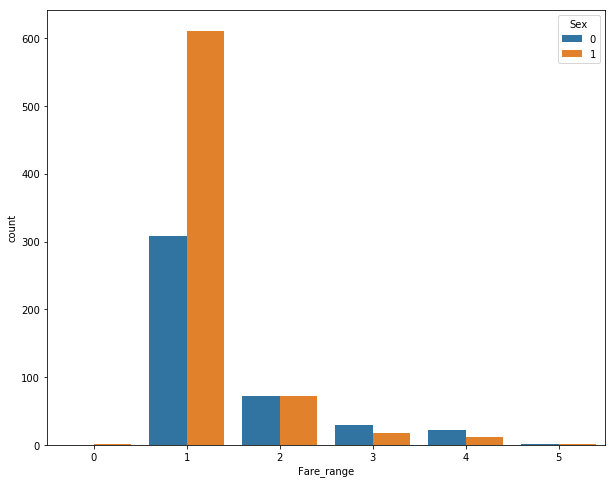

In [51]:
# fare distribution per gender
fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot('Fare_range', hue = 'Sex', data = dataset, ax = ax)

Males are the ones that paid more than females but this is probably because our dataset contains more males than females. However, we see that when it comes to fare range 2 (51-100), males and females seem to have paid the same amount.

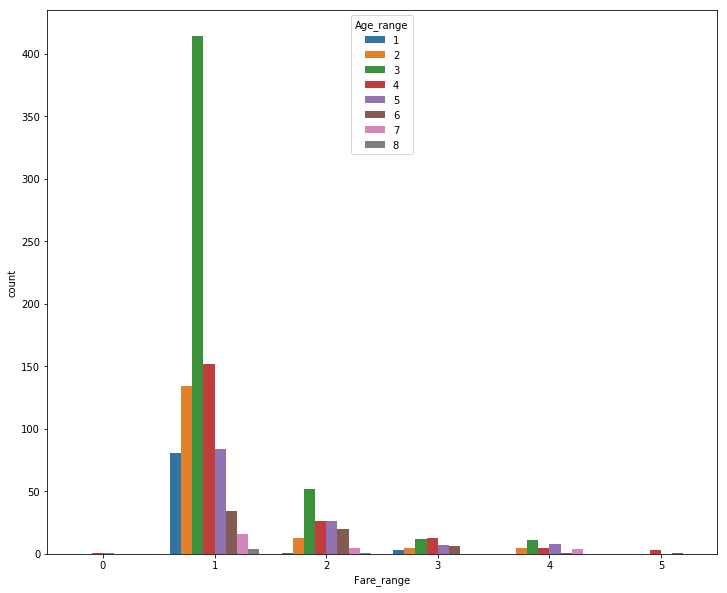

In [52]:
# fare distribution across age
fig, ax = plt.subplots(figsize = (12, 10))
sns.countplot('Fare_range', hue = 'Age_range', data = dataset, ax = ax)

Most age groups are in fare range 1 (0-50). An interesting detail I've noticed is that for fare range 3 (101-200), it's the 30-40 year olds who are mostly the ones paying this fare and not the 20-30 year olds like with the other fare ranges. The same can be said for fare range 5 (301-515).

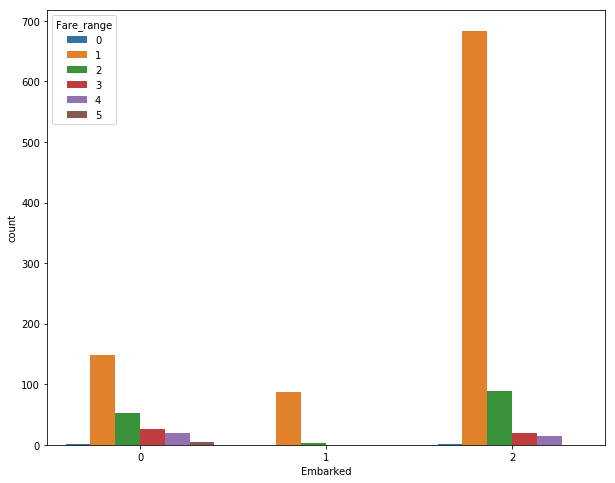

In [53]:
# relationship between fare and point of embarkment
fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot('Embarked', hue = 'Fare_range', data = dataset, ax = ax)

As expected, point S has the most records of fares with majority of them being in fare range 1 (0-50).

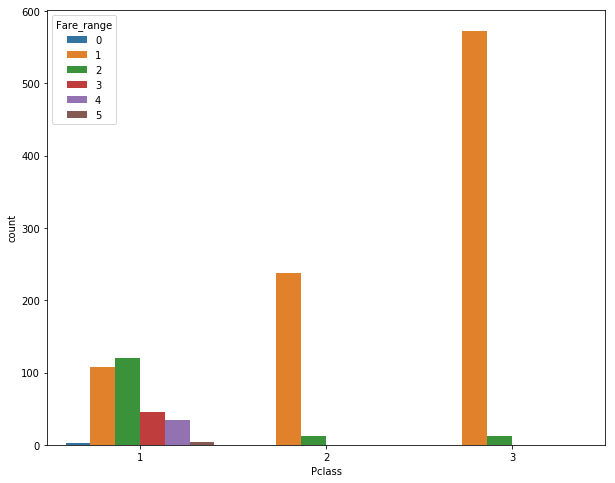

In [54]:
# fare distribution per class
fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot('Pclass', hue = 'Fare_range', data = dataset, ax = ax)

It makes logical sense that 1st class would have a more diverse set of fares than 2nd or 3rd class since it's more costly to be in 1st class than the other classes.

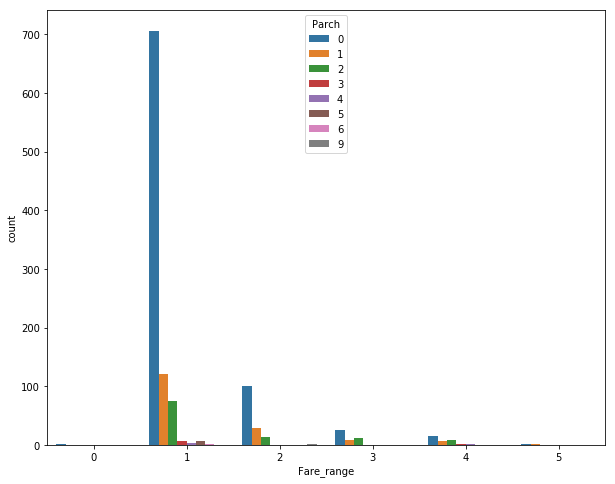

In [55]:
# fare per parent-child
fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot('Fare_range', hue = 'Parch', data = dataset, ax = ax)

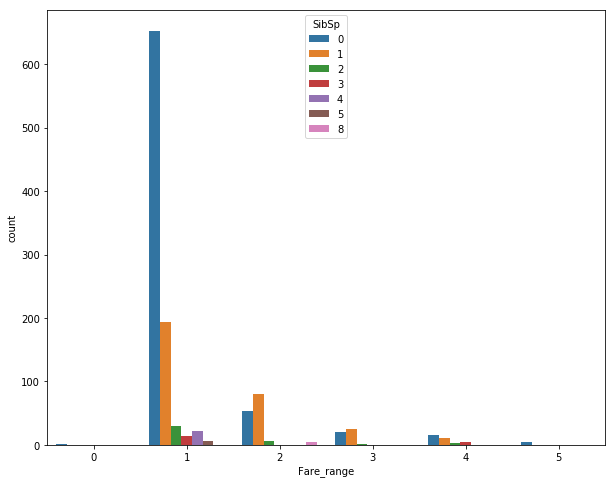

In [56]:
# fare per siblings/spouses
fig, ax = plt.subplots(figsize = (10, 8))
sns.countplot('Fare_range', hue = 'SibSp', data = dataset, ax = ax)

For both the parent-childand sibling-spouse variables, we don't see anything unusual.

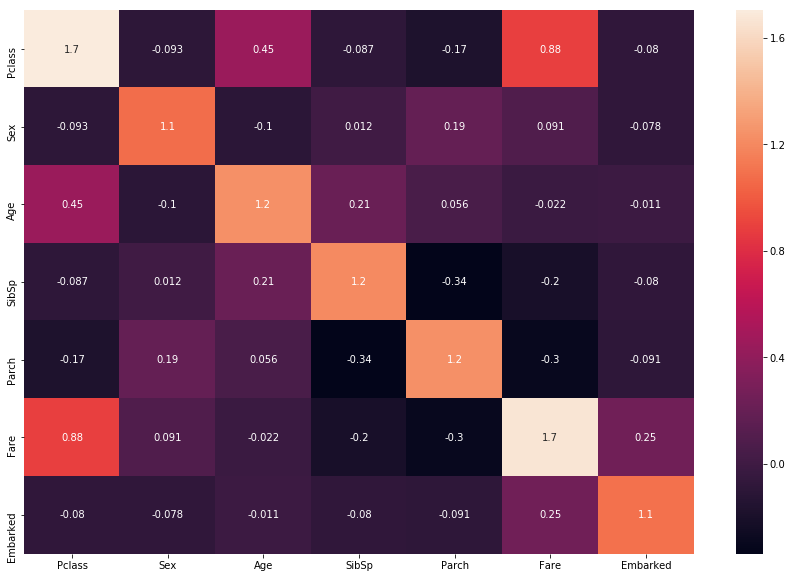

In [57]:
# checking for multicollinearity
corr = dataset.corr()
vif = pd.DataFrame(np.linalg.inv(corr.values), index = corr.index, columns = corr.columns)

# using a heatmap to display the results
plt.figure(figsize = (15, 10))
sns.heatmap(vif, annot = True)

All our variables have Variance Inflation Factor (VIF) scores which are nowhere near 5, which would have made them really problematic. So we see that there is no need of dropping any columns.

# 4. Modeling - K Nearest Neighbor (KNN)

For modelling, we will use our 'train' dataset since the 'test' one does not have any values for Survived.

In [58]:
# splitting our data into attributes and label
X = train.drop(columns = ['Survived']).values
y = train['Survived'].values
print(X.shape)
print(y.shape)

(772, 7)
(772,)


### 4.1 KNN without splitting

In [59]:
from sklearn.neighbors import KNeighborsClassifier

# fitting the classifier
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(X, y)

# making predictions
y_pred = classifier.predict(X)

# evaluating the classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Accuracy score:",accuracy_score(y, y_pred))

print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

Accuracy score: 0.7914507772020726
[[389  65]
 [ 96 222]]
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       454
           1       0.77      0.70      0.73       318

    accuracy                           0.79       772
   macro avg       0.79      0.78      0.78       772
weighted avg       0.79      0.79      0.79       772



We see that the accuracy of our model without splitting the data into train and test sets is 79%.

### 4.2 KNN with train-test splits

We will use a loop to loop through a list of possible test cases to determine which one provides the best accuracy.

In [60]:
my_tests = [0.1, 0.2, 0.3, 0.4, 0.5]

from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler

for test in my_tests:
    X_train, X_test, y_train, y_test = tts(X, y, test_size = test, random_state = 12)
    
    # scaling the training data
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # fitting to classifier
    classifier = KNeighborsClassifier(n_neighbors = 5)
    classifier.fit(X_train, y_train)
    
    # making predictions
    y_pred = classifier.predict(X_test)

    # evaluating the algorithm
    print("Test size {} has Accuracy score:".format(test),accuracy_score(y_test, y_pred))

Test size 0.1 has Accuracy score: 0.7948717948717948
Test size 0.2 has Accuracy score: 0.7870967741935484
Test size 0.3 has Accuracy score: 0.771551724137931
Test size 0.4 has Accuracy score: 0.7961165048543689
Test size 0.5 has Accuracy score: 0.7979274611398963


From this we can conclude the following:
- test size 0.1 (train size 0.9) has about 79.4% accuracy
- test size 0.2 (train size 0.8) has about 78.7% accuracy
- test size 0.3 (train size 0.7) has about 77.1% accuracy
- test size 0.4 (train size 0.6) has about 79.6% accuracy
- test size 0.5 (train size 0.5) has about 79.7% accuracy

It does not seem logical to use a 50-50 train-test split so we will use the next best one, which is the 60-40 split. We can see that it is indeed more accurate than carrying out the predictions without splitting the dataset into training and testing sets. 

### 4.3 KNN Hyperparameter Tuning

##### 4.3.1 90-10 split

In [61]:
# dictionary to store accuracy scores
acc_results = {}

# selecting 90-10 train-test split
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.1, random_state = 12)

neighbor_range = np.arange(1, 51)

for nei in neighbor_range: 
    classifier = KNeighborsClassifier(n_neighbors = nei)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    acc_results[nei] = accuracy

# getting the most accurate k value
key_list = list(acc_results.keys())
value_list = list(acc_results.values())
max_acc = pd.Series(acc_results).max()
max_k = key_list[value_list.index(pd.Series(acc_results).max())]
print("A k value of {} for this train-test split resulted in an accuracy of {}".format(max_k,
                                                                                       (max_acc * 100)))

A k value of 6 for this train-test split resulted in an accuracy of 74.0


In [62]:
# optimizing by normalizing
from sklearn.preprocessing import Normalizer
normal = Normalizer()
X_train = normal.fit_transform(X_train)
X_test = normal.transform(X_test)

from sklearn.model_selection import KFold, RandomizedSearchCV

knn = KNeighborsClassifier()

params = {'n_neighbors' : neighbor_range,
         'weights' : ['uniform', 'distance'],
         'metric' : ['manhattan', 'euclidean', 'minkowski']}

kfolds = KFold(n_splits = 20)
rscv = RandomizedSearchCV(knn, params, random_state = 12)
rscv.fit(X_train, y_train)
print("Best parameters:", rscv.best_params_)

Best parameters: {'weights': 'distance', 'n_neighbors': 34, 'metric': 'manhattan'}


In [63]:
# now implementing using the recommended best parameters
classifier = KNeighborsClassifier(n_neighbors = 34, weights = 'distance', metric = 'manhattan')
classifier.fit(X_train, y_train)

# making predictions
y_pred = classifier.predict(X_test)

# evaluating the algorithm
print("Accuracy score:", accuracy_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy score: 0.7051282051282052
[[35 12]
 [11 20]]
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        47
           1       0.62      0.65      0.63        31

    accuracy                           0.71        78
   macro avg       0.69      0.69      0.69        78
weighted avg       0.71      0.71      0.71        78



Before playing around with the parameters, the accuracy score for the 90-10 split was 79.4%. 

Playing around with the best value of k resulted in an accuracy score of 74% for k = 6. 

A randomized search returned best parameters 'distance' for weights, 34 for n_neighbors, and 'manhattan' for metrics and resulted in an accuracy score of 70.5%.

We see that hyperparameter tuning has actually brought down the accuracy score.

##### 4.3.2 80-20 split

In [64]:
# dictionary to store accuracy scores
acc_results = {}

# selecting 80-20 train-test split
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.2, random_state = 12)

for nei in neighbor_range: 
    classifier = KNeighborsClassifier(n_neighbors = nei)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    acc_results[nei] = accuracy

# getting the most accurate k value
key_list = list(acc_results.keys())
value_list = list(acc_results.values())
max_acc = pd.Series(acc_results).max()
max_k = key_list[value_list.index(pd.Series(acc_results).max())]
print("A k value of {} for this train-test split resulted in an accuracy of {}".format(max_k, 
                                                                                       (max_acc * 100)))

A k value of 13 for this train-test split resulted in an accuracy of 72.0


In [65]:
# optimizing by normalizing
normal = Normalizer()
X_train = normal.fit_transform(X_train)
X_test = normal.transform(X_test)

neighbor_range = np.arange(1, 51)
knn = KNeighborsClassifier()

params = {'n_neighbors' : neighbor_range,
         'weights' : ['uniform', 'distance'],
         'metric' : ['manhattan', 'euclidean', 'minkowski']}

kfolds = KFold(n_splits = 20)
rscv = RandomizedSearchCV(knn, params, random_state = 12)
rscv.fit(X_train, y_train)
print("Best parameters:", rscv.best_params_)

Best parameters: {'weights': 'distance', 'n_neighbors': 39, 'metric': 'manhattan'}


In [66]:
# now implementing using the recommended best parameters
classifier = KNeighborsClassifier(n_neighbors = 39, weights = 'distance', metric = 'manhattan')
classifier.fit(X_train, y_train)

# making predictions
y_pred = classifier.predict(X_test)

# evaluating the algorithm
print("Accuracy score:", accuracy_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy score: 0.6580645161290323
[[66 30]
 [23 36]]
              precision    recall  f1-score   support

           0       0.74      0.69      0.71        96
           1       0.55      0.61      0.58        59

    accuracy                           0.66       155
   macro avg       0.64      0.65      0.64       155
weighted avg       0.67      0.66      0.66       155



Before playing around with the parameters, the accuracy score for the 80-20 split was 78.7%. 

Playing around with the best value of k resulted in an accuracy score of 72% for k = 13. 

A randomized search returned best parameters 'distance' for weights, 39 for n_neighbors, and 'manhattan' for metrics and resulted in an accuracy score of 65.8%.

We see that hyperparameter tuning has actually brought down the accuracy score.

##### 4.3.3 70-30 split

In [67]:
# dictionary to store accuracy scores
acc_results = {}

# selecting 70-30 train-test split
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.3, random_state = 12)

for nei in neighbor_range: 
    classifier = KNeighborsClassifier(n_neighbors = nei)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    acc_results[nei] = accuracy

# getting the most accurate k value
key_list = list(acc_results.keys())
value_list = list(acc_results.values())
max_acc = pd.Series(acc_results).max()
max_k = key_list[value_list.index(pd.Series(acc_results).max())]
print("A k value of {} for this train-test split resulted in an accuracy of {}".format(max_k, 
                                                                                       (max_acc * 100)))

A k value of 20 for this train-test split resulted in an accuracy of 72.0


In [68]:
# optimizing by normalizing
normal = Normalizer()
X_train = normal.fit_transform(X_train)
X_test = normal.transform(X_test)

neighbor_range = np.arange(1, 51)
knn = KNeighborsClassifier()

params = {'n_neighbors' : neighbor_range,
         'weights' : ['uniform', 'distance'],
         'metric' : ['manhattan', 'euclidean', 'minkowski']}

kfolds = KFold(n_splits = 20)
rscv = RandomizedSearchCV(knn, params, random_state = 12)
rscv.fit(X_train, y_train)
print("Best parameters:", rscv.best_params_)

Best parameters: {'weights': 'distance', 'n_neighbors': 34, 'metric': 'manhattan'}


In [69]:
# now implementing using the recommended best parameters
classifier = KNeighborsClassifier(n_neighbors = 34, weights = 'distance', metric = 'manhattan')
classifier.fit(X_train, y_train)

# making predictions
y_pred = classifier.predict(X_test)

# evaluating the algorithm
print("Accuracy score:", accuracy_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy score: 0.6896551724137931
[[101  42]
 [ 30  59]]
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       143
           1       0.58      0.66      0.62        89

    accuracy                           0.69       232
   macro avg       0.68      0.68      0.68       232
weighted avg       0.70      0.69      0.69       232



Before playing around with the parameters, the accuracy score for the 70-30 split was 77.1%. 

Playing around with the best value of k resulted in an accuracy score of 72% for k = 20. 

A randomized search returned best parameters 'distance' for weights, 34 for n_neighbors, and 'manhattan' for metrics and resulted in an accuracy score of 68.9%.

We see that hyperparameter tuning has actually brought down the accuracy score.

##### 4.3.4 60-40 split

In [70]:
# dictionary to store accuracy scores
acc_results = {}

# selecting 60-40 train-test split
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.4, random_state = 12)

for nei in neighbor_range: 
    classifier = KNeighborsClassifier(n_neighbors = nei)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    acc_results[nei] = accuracy

# getting the most accurate k value
key_list = list(acc_results.keys())
value_list = list(acc_results.values())
max_acc = pd.Series(acc_results).max()
max_k = key_list[value_list.index(pd.Series(acc_results).max())]
print("A k value of {} for this train-test split resulted in an accuracy of {}".format(max_k, 
                                                                                       (max_acc * 100)))

A k value of 18 for this train-test split resulted in an accuracy of 72.0


In [71]:
# optimizing by normalizing
normal = Normalizer()
X_train = normal.fit_transform(X_train)
X_test = normal.transform(X_test)

neighbor_range = np.arange(1, 51)
knn = KNeighborsClassifier()

params = {'n_neighbors' : neighbor_range,
         'weights' : ['uniform', 'distance'],
         'metric' : ['manhattan', 'euclidean', 'minkowski']}

kfolds = KFold(n_splits = 20)
rscv = RandomizedSearchCV(knn, params, random_state = 12)
rscv.fit(X_train, y_train)
print("Best parameters:", rscv.best_params_)

Best parameters: {'weights': 'distance', 'n_neighbors': 34, 'metric': 'manhattan'}


In [72]:
# now implementing using the recommended best parameters
classifier = KNeighborsClassifier(n_neighbors = 34, weights = 'distance', metric = 'manhattan')
classifier.fit(X_train, y_train)

# making predictions
y_pred = classifier.predict(X_test)

# evaluating the algorithm
print("Accuracy score:", accuracy_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy score: 0.7055016181229773
[[137  55]
 [ 36  81]]
              precision    recall  f1-score   support

           0       0.79      0.71      0.75       192
           1       0.60      0.69      0.64       117

    accuracy                           0.71       309
   macro avg       0.69      0.70      0.70       309
weighted avg       0.72      0.71      0.71       309



Before playing around with the parameters, the accuracy score for the 60-40 split was 79.6%. 

Playing around with the best value of k resulted in an accuracy score of 72% for k = 18. 

A randomized search returned best parameters 'distance' for weights, 34 for n_neighbors, and 'manhattan' for metrics and resulted in an accuracy score of 70.5%.

We see that hyperparameter tuning has actually brought down the accuracy score.

# 5. Conclusion & Challenging the Solution

To conclude, we see that the accuracy score is highest for the 60-40 split without any hyperparameter tuning (79.6%). With hyperparameter tuning, the accuracy score went down, which means that either there is something wrong with the model or we did not use the correct model for this. We will challenge our solution by applying gradient boosting.

In [73]:
# use Gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

# selecting 60-40 train-test split
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.4, random_state = 12)

# setting different learning rates, so that we can compare the performance of 
# the classifier's performance at different learning rates
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gbc = GradientBoostingClassifier(n_estimators = 200, max_depth = 2,
                                     learning_rate = learning_rate,
                                     random_state = 12)
    gbc.fit(X_train, y_train)

    print("Learning rate:", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gbc.score(X_train,
                                                                   y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gbc.score(X_test,
                                                                     y_test)))
    print("*******************************************")

Learning rate: 0.05
Accuracy score (training): 0.847
Accuracy score (validation): 0.793
*******************************************
Learning rate: 0.075
Accuracy score (training): 0.862
Accuracy score (validation): 0.796
*******************************************
Learning rate: 0.1
Accuracy score (training): 0.881
Accuracy score (validation): 0.806
*******************************************
Learning rate: 0.25
Accuracy score (training): 0.937
Accuracy score (validation): 0.799
*******************************************
Learning rate: 0.5
Accuracy score (training): 0.972
Accuracy score (validation): 0.741
*******************************************
Learning rate: 0.75
Accuracy score (training): 0.978
Accuracy score (validation): 0.744
*******************************************
Learning rate: 1
Accuracy score (training): 0.985
Accuracy score (validation): 0.709
*******************************************


We can see that a learning rate of 0.1 gives us the best performance when it comes to validating, and good performance when it comes to training so we will use it as our parameter.

In [74]:
# now to use our selected learning rate to model
grad = GradientBoostingClassifier(n_estimators = 200, max_depth = 2, 
                                  learning_rate = 0.1, random_state = 0)

# fitting to training data
grad.fit(X_train, y_train)

# making predictions
grad_y_pred = grad.predict(X_test)

# evaluating the algorithm
print("Confusion Matrix:")
print(confusion_matrix(y_test, grad_y_pred))
print("Classification Report")
print(classification_report(y_test, grad_y_pred))

Confusion Matrix:
[[161  31]
 [ 29  88]]
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       192
           1       0.74      0.75      0.75       117

    accuracy                           0.81       309
   macro avg       0.79      0.80      0.79       309
weighted avg       0.81      0.81      0.81       309



Accuracy has gone up to 81% by using gradient boosting, which is a slight improvement but passes the metric for success.